# Import required modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy

In [2]:
import session_info
session_info.show()

/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/rfs/project/rfs-iCNyzSAaucw/kk837/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/fetal_ms_figures'

# Read in anndata

In [6]:
adata_vis = sc.read_h5ad('/rfs/project/rfs-iCNyzSAaucw/kk837/data_objects/Foetal/Visium/visium_foetal_healthy-all_raw.h5ad')
adata_vis

/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 39223 × 33562
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'region_cluster', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts'

In [8]:
# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_vis.obs['annotation_final_mod']=adata_vis.obs['annotation_final'].astype('str').copy()
adata_vis.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].astype('category')

#reorder annotations
annotations_order = [
   'Atrium',
        'Ventricle - Compact',
     'Ventricle - Trabeculated',
        'SAnode',
        'AVnode',
    'VCS - Proximal',
        'VCS - Distal',
        'Great vessel',
        'Coronary vessel',
    'Ductus arteriosus',
        'Adventitia - Coronary',
     'Adventitia - GV',
    'Epicardium',
        'Endocardium - Atrial', 
    'Endocardium - Ventricular',
        'Endocardial cusion',
        'AV ring',
    'Valves',
    'LN',
            ]
adata_vis.obs['annotation_final_mod'] = adata_vis.obs['annotation_final_mod'].cat.reorder_categories(annotations_order)

# Preapare cell2location output anndata

In [11]:
# get the cell2loc output
cell2loc_out = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()
## read in cell type name update dictionary
celltype_rename = utils.read_pkl('/rfs/project/rfs-iCNyzSAaucw/kk837/data_objects/Foetal/fine_grain_rename_dictionary.pkl')
## update cell type name
cellnames = adata_vis.obsm['q05_cell_abundance_w_sf'].columns
cellnames = [x.split('q05cell_abundance_w_sf_')[1] for x in cellnames]
cellnames = [celltype_rename[x] for x in cellnames]

# select obs columns
obs_columns = ['array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
               'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 
               'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei',
               'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'annotation_final','annotation_final_mod']

# make anndata
adata_c2l = anndata.AnnData(
    X=adata_vis.obsm['q05_cell_abundance_w_sf_ndarray'].copy(),
    obs=adata_vis.obs[obs_columns],
    var=pd.DataFrame(cellnames).set_index(0),
    obsm=adata_vis.obsm.copy(),
    obsp=adata_vis.obsp.copy(),
    uns=adata_vis.uns.copy()
)
adata_c2l

AnnData object with n_obs × n_vars = 39223 × 58
    obs: 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'week', 'leiden', 'annotation_final', 'annotation_final_mod'
    uns: 'JC_edit_colors', 'annotation_colors', 'annotation_final_colors', 'cell2loc-map_group_colors', 'leiden', 'neighbors', 'region_cluster_colors', 'sample_for_cell2loc_colors', 'umap'
    obsm: 'MT', 'X_umap', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q05_cell_abundance_w_sf_ndarray', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'
    obsp: 'connec

In [18]:
df = pd.read_csv('/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/finegrain_name_mapping.csv').set_index('Full_name')
mapping = df['Short_name_finalised'].to_dict()
'AtrialCardiomyocytesLeft' in mapping.keys()

True

In [20]:
# map fine-grained cell types to short version# map cell type name to short versions
df = pd.read_csv('/rfs/project/rfs-iCNyzSAaucw/kk837/notebooks/Foetal/finegrain_name_mapping.csv').set_index('Full_name')
mapping = df['Short_name_finalised'].to_dict()
adata_c2l.var_names = [mapping[x] if x in mapping.keys() else x for x in adata_c2l.var_names]
adata_c2l.var

""
aCML
aCMR
vCMCL
vCMCR
vCMTL
vCMTR
SANPC
AVNPC
VCSProx
VCSDist


# Select regions and cells to plot

In [21]:
# make the value 0 below an arbitrary threshold
# to calculate proportion
abundance_thresh = 0.05
adata_c2l.raw = adata_c2l
adata_c2l.X[adata_c2l.X<abundance_thresh] = 0
adata_c2l.X = scipy.sparse.csr_matrix(adata_c2l.X)

/tmp/ipykernel_295047/1462688745.py:5: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  adata_c2l.X[adata_c2l.X<abundance_thresh] = 0
/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [22]:
# select regions
# regions without LN
regions_sel = [ 'Great vessel',
               'Ductus arteriosus',
               'Coronary vessel',
                'Adventitia - GV',
               'Adventitia - Coronary',
               'AV ring',
               'Valves',
               'Atrium',
               'SAnode',
               'AVnode',
               'VCS - Proximal',
               'VCS - Distal',
               'Ventricle - Trabeculated',
               'Ventricle - Compact',
                'Epicardium',
               'Endocardium - Atrial',
               'Endocardium - Ventricular',        
               'Endocardial cusion',
 ]
ad = adata_c2l[adata_c2l.obs['annotation_final_mod'].isin(regions_sel)]

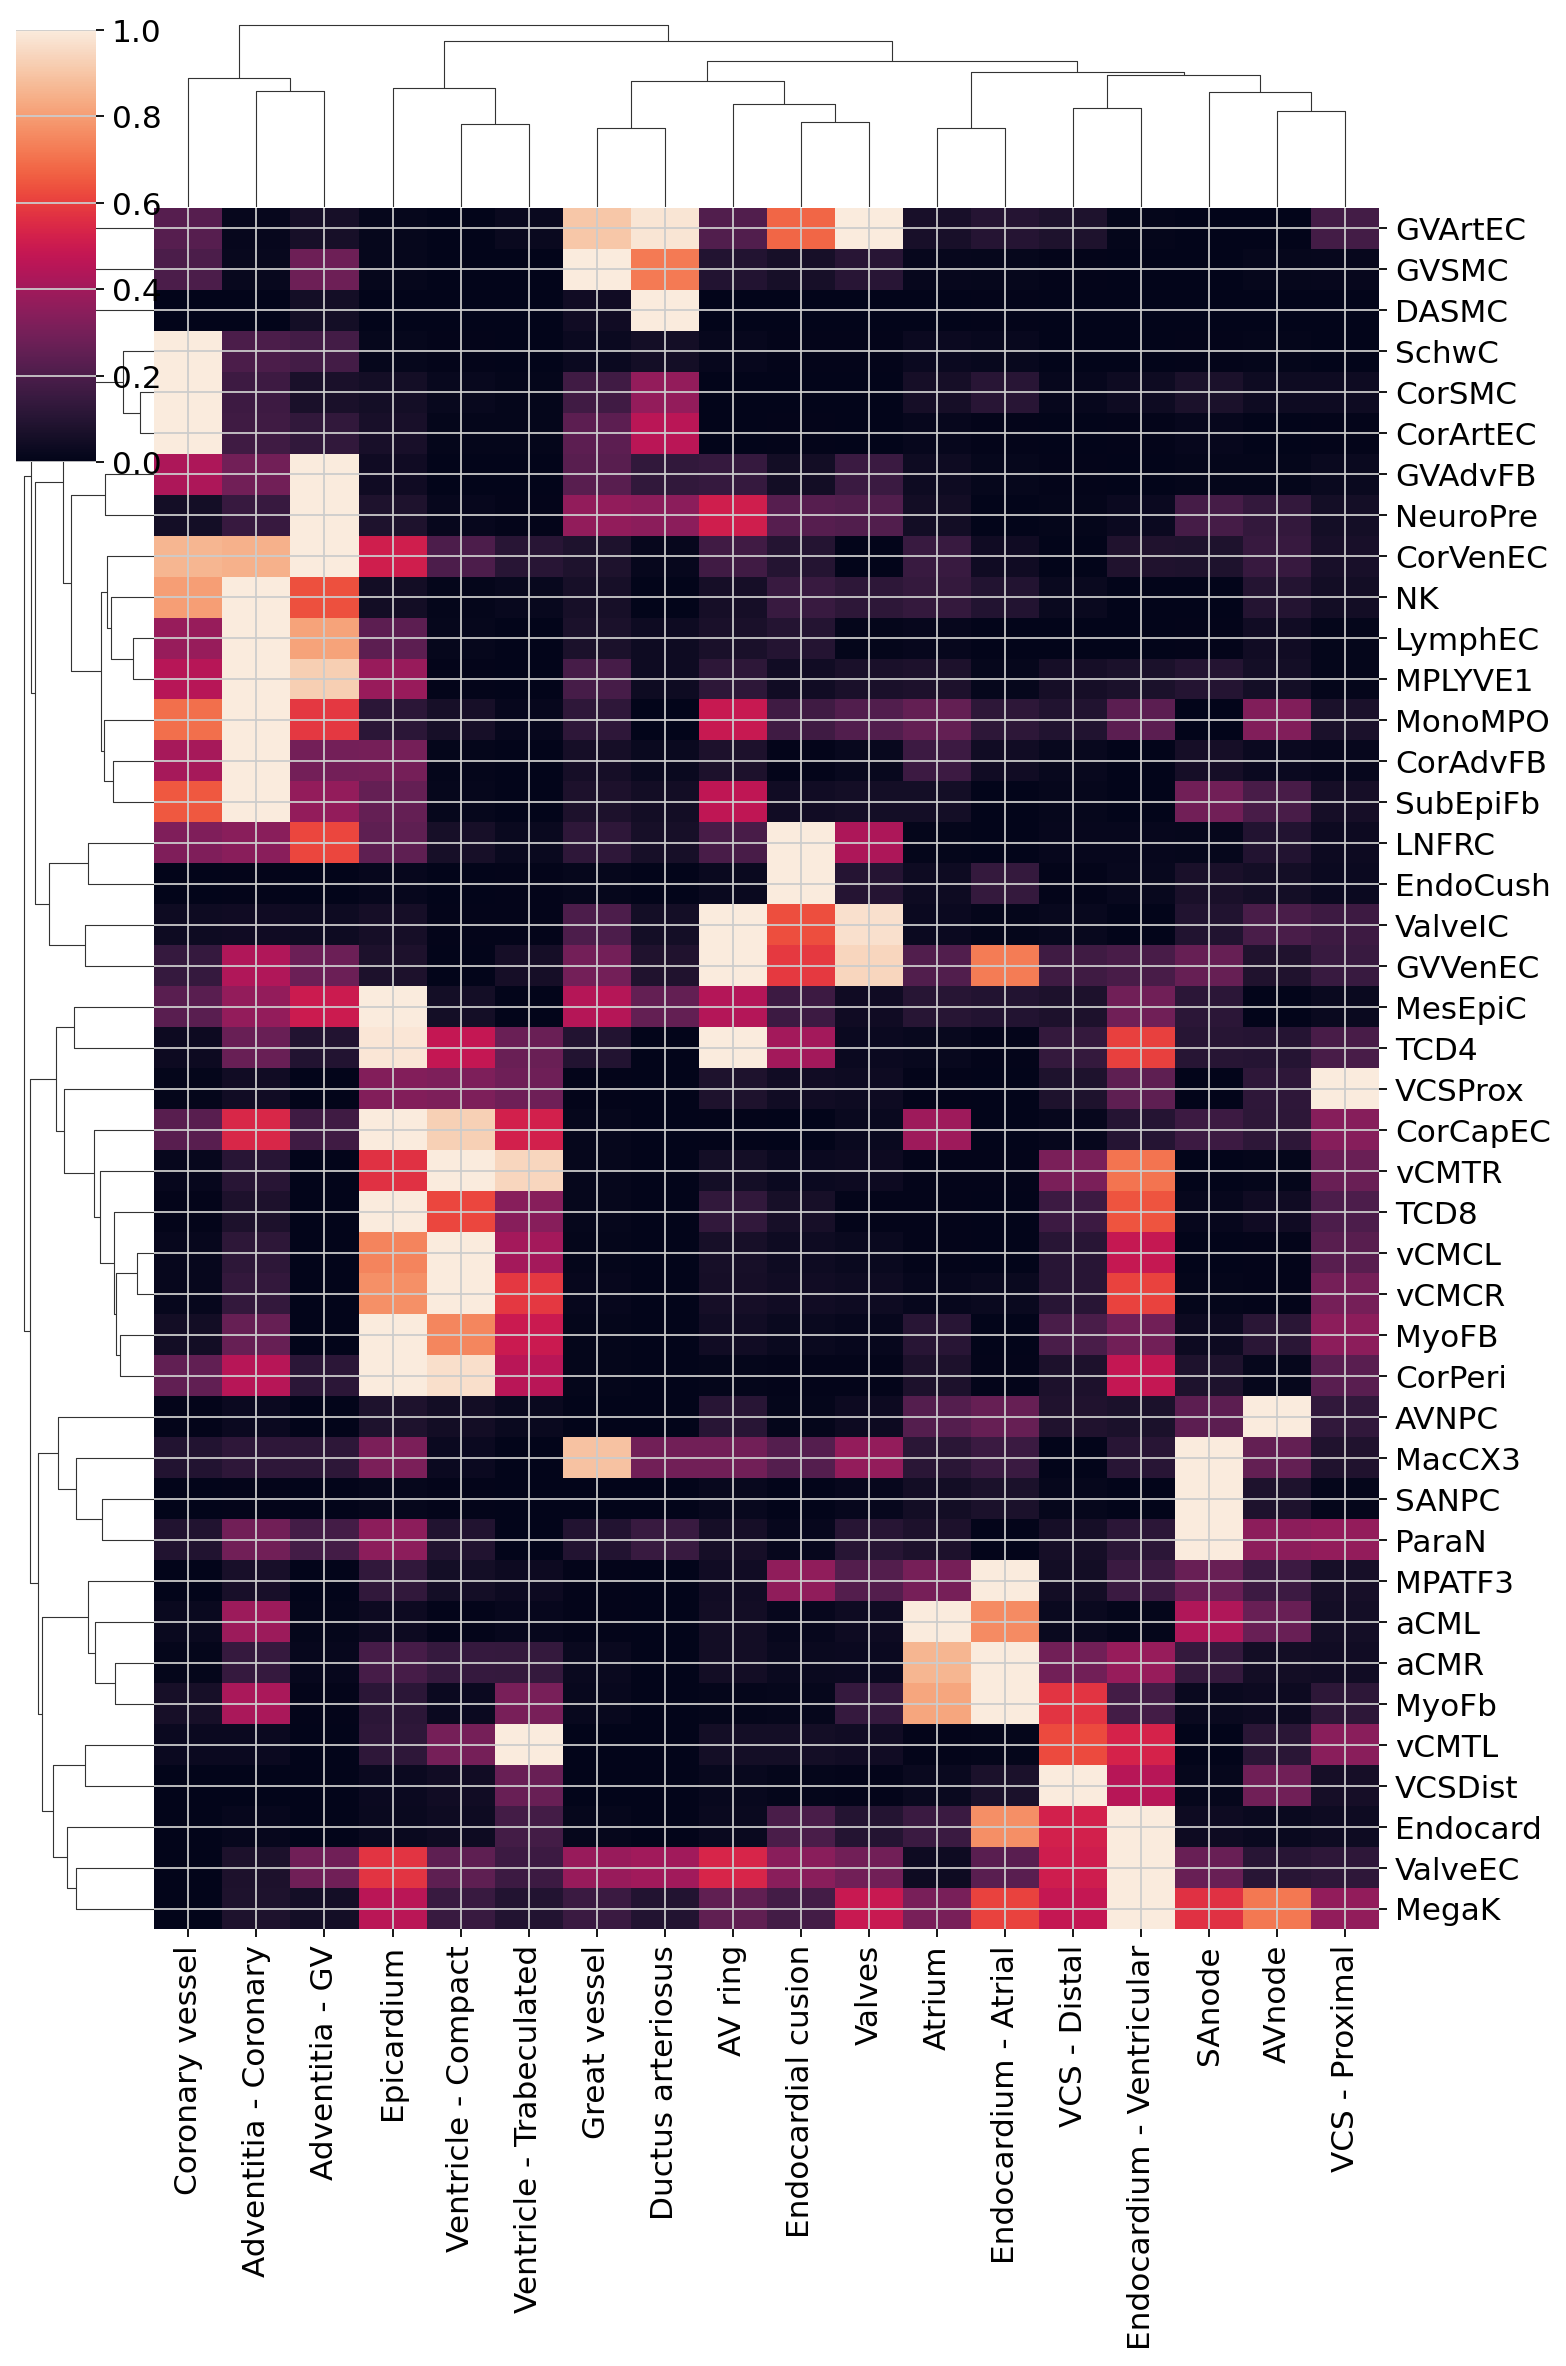

In [23]:
# select cells to plot based on expression proportion

## calculate expression proportion
exp_prop = utils.get_exp_proportion(ad,groupby='annotation_final_mod', use_rep='X')

## select cells which are above an arbitrary threshold at any of the niches
prop_thresh = 0.4
cells_sel = list(exp_prop.max(axis=1).index[exp_prop.max(axis=1)>prop_thresh])

# get cell order based on hierarchical clustering
## mean abundance per niche
exp_mean = utils.grouped_obs_mean(ad[:,cells_sel], group_key='annotation_final_mod').T
## min-max normalisation
exp_mean_scaled = (exp_mean-exp_mean.min())/(exp_mean.max()-exp_mean.min())
## clustering
g = sns.clustermap(exp_mean_scaled.T, figsize=(10,15), dendrogram_ratio=0.1)
row_order = g.dendrogram_row.reordered_ind
cell_order = exp_mean_scaled.columns[row_order]

# Dot plot

/tmp/ipykernel_295047/3506546109.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['annotation_final_mod'] = ad.obs['annotation_final_mod'].astype('category')
/home/kk837/.conda/envs/generic_env/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 58 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


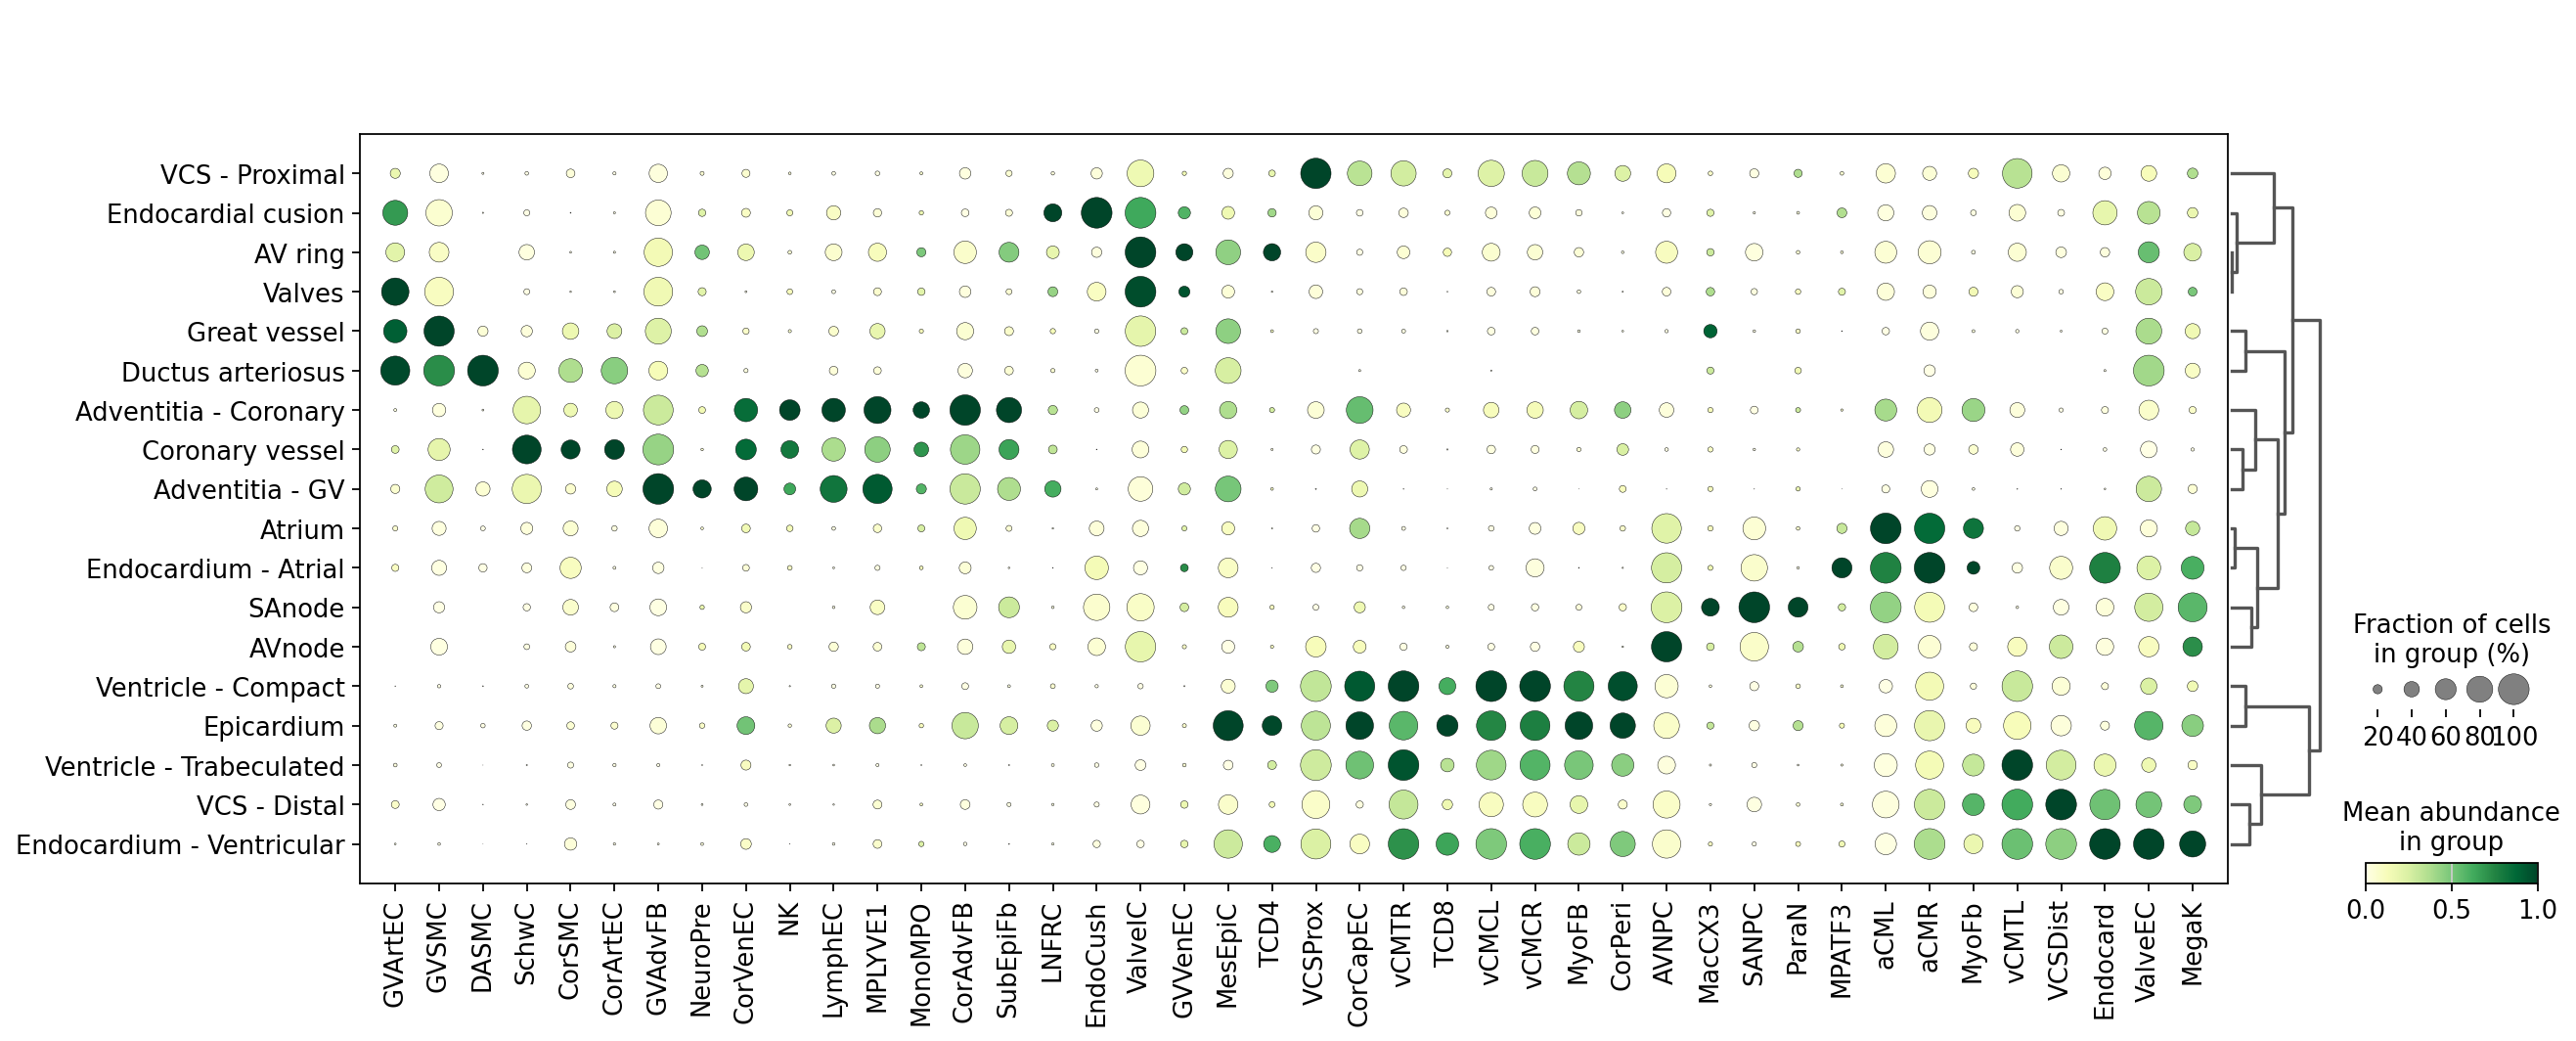

In [24]:
ad = adata_c2l[adata_c2l.obs['annotation_final_mod'].isin(regions_sel)]
ad.obs['annotation_final_mod'] = ad.obs['annotation_final_mod'].astype('category')
ad.obs['annotation_final_mod'] = ad.obs['annotation_final_mod'].cat.reorder_categories(regions_sel)

sc.tl.dendrogram(ad, groupby='annotation_final_mod')

sc.pl.dotplot(ad,
              var_names=cell_order,
              standard_scale='var',
              groupby='annotation_final_mod',
                               dendrogram=True,
             cmap='YlGn',
              colorbar_title='Mean abundance\nin group',
              show=False
                  )
plt.savefig(f"{figdir}/visium_tissue-by-celltype_dotplot.pdf", bbox_inches="tight",dpi=300)